# Project: Measuring News Article Deviation from Ground Truth

### Authors
Braulio Bracamontes, Fernando Munoz, and Rogelio Valles

## Introduction

In today's digital age, news is published by numerous sources—each potentially offering a slightly different perspective on the same event. This variation can lead to confusion or misinformation, especially when articles omit or distort key facts. Our project addresses this challenge by developing a system to evaluate how closely a given news article aligns with the collective reporting of other articles on the same event.

## Motivation

Readers rarely have time to cross-reference dozens of articles to spot inconsistencies or biased reporting. We aim to automate this process by:
- Aggregating multiple articles on a single event,
- Extracting common details to define a shared "ground truth",
- Comparing new articles to this baseline to measure their **deviation**.

This can help flag outlier articles that significantly differ in content or emphasis, potentially identifying biased, low-quality, or misleading reporting.

## Goal

Our objective is to build a system that:
- Fetches news articles from multiple sources using NewsAPI,
- Embeds the textual content of these articles using a pre-trained language model,
- Extracts a semantic “ground truth” from frequently recurring named entities and facts,
- Calculates similarity scores between each article and the ground truth to quantify deviation.

The final result is a framework capable of comparing journalistic consistency across multiple sources, offering insights into how information is presented and varied.


## Environment Setup and Imports

This section imports the necessary libraries and project modules required for the notebook. These include:

- Standard Python libraries (`os`, `sys`, `pandas`) for file management and data processing,
- `dotenv` to load environment variables, such as the API key,
- Custom project modules from the `src` directory, which include:
  - `HuggingFaceEmbeddings` for generating text embeddings,
  - `utils` for helper functions related to preprocessing and scoring.


In [5]:
import os
import sys
import pandas as pd
from dotenv import load_dotenv
from src.nlp_models import HuggingFaceEmbeddings
from src import utils

In [6]:
# --- Setup paths ---
BASE_DIR = os.getcwd()
SRC_DIR = f'{BASE_DIR}/src'
OUTPUT_DIR = f'{BASE_DIR}/outputs'

sys.path.append(str(SRC_DIR))

# --- Load environment variables ---
load_dotenv(f'{BASE_DIR}/.env')

True

## Article Collection


The `fetch_articles` function, defined in our `articles.py` module, sends HTTP requests to [TheNewsAPI](https://www.thenewsapi.com/) to retrieve news data matching a given query. It uses parameters such as:

- `query`: the search string used to filter relevant articles,
- `language`: language of the articles (e.g., "en" for English),
- `total_articles`: the maximum number of articles to collect,
- `page_size`: number of articles retrieved per request,
- `published_after` / `published_before`: optional date filters to restrict the publication window.

Each article returned by the API is processed to extract its full body text using the `newspaper3k` library. The `extract_full_text` function downloads and parses each article from its URL to obtain clean, readable content.

The resulting list of articles includes fields such as title, body, source, publication date, and URL, which are saved to a CSV file for further analysis.

To reproduce this step, you will need a valid NewsAPI key stored in your `.env` file as `THENEWSAPI_KEY`.


In [7]:
# --- Parameters ---
SEARCH_QUERY = "2024 Champions League Final"
LANGUAGE = "en"
TOTAL_ARTICLES = 100
PAGE_SIZE = 5
TOPIC_LABEL = "champions+league+2024"
PUBLISHED_AFTER = "2024-01-01"

ARTICLES_CSV = f'{OUTPUT_DIR}/articles.csv'
EMBEDDED_CSV = f'{OUTPUT_DIR}/embedded_articles.csv'
SCORED_CSV = f'{OUTPUT_DIR}/articles_scored.csv'
GROUND_TRUTH_TXT = f'{OUTPUT_DIR}/ground_truth.txt'

Part 1: Fetch articles and store them to a dataframe object
===
The articles where downloaded using the NewsAPI resource available online. We downloaded a total of 100 articles saved in the ```outputs/articles.csv``` location.

If you wish to download another set of articles you would have to run the code seen below, but you'd have to obtain a new API key from the resource [available here](https://newsapi.org/) and store that key in the variable ```THENEWSAPI_KEY``` in your .env file.

```python
print("Fetching articles...")
articles = fetch_articles(
    query=SEARCH_QUERY,
    language=LANGUAGE,
    total_articles=TOTAL_ARTICLES,
    page_size=PAGE_SIZE,
    topic_label=TOPIC_LABEL,
    published_after=PUBLISHED_AFTER
)
```

Now you can see that the structure of the dataframe containing our article data below

In [8]:
df_articles = pd.read_csv(ARTICLES_CSV)
df_articles.head(3)

,article_id,title,body,source,published_at,url
0,0cd1f952-eb81-44ed-9792-5c854acfaeb4,Date confirmed for CAF Champions League quarte...,CAF has announced the date and venue for the q...,thesouthafrican.com,2025-02-05T09:49:17.000000Z,https://www.thesouthafrican.com/sport/soccer/c...
1,e3f890d4-4637-4dde-a45d-89c0f61a9046,"Champions League final, Premier League race: M...",Open Extended Reactions\n\nWith PSG and Boruss...,espn.co.uk,2024-05-02T15:35:23.000000Z,https://www.espn.co.uk/football/story/_/id/400...
2,83888beb-8b74-4e0e-8b46-97541b03ca31,"Champions League final, Premier League race: M...",Open Extended Reactions\n\nWith PSG and Boruss...,espn.com,2024-05-02T12:31:53.000000Z,https://www.espn.com/soccer/story/_/id/4005714...


## Part 2: Generate Text Embeddings

To analyze the content of each article quantitatively, we convert the article body text into fixed-size vector representations known as embeddings. These embeddings capture the semantic meaning of the text and allow us to compare articles in a meaningful way.

We use a custom `HuggingFaceEmbeddings` class from the `nlp_models.py` module, which utilizes a pre-trained model from the `sentence-transformers` library. Specifically, we use the `all-MiniLM-L6-v2` model, a lightweight yet effective transformer model suitable for sentence-level embeddings.

The embedding process involves the following steps:
- Each article's body text is passed through the transformer model,
- The model outputs a 384-dimensional embedding vector for each article,
- The resulting vectors are stored alongside the original metadata in a new DataFrame.

The embedding vectors are saved to a CSV file (`embedded_articles.csv`) and later reloaded into the notebook for continued processing. After merging, the shape of the resulting DataFrame becomes (98, 390), where:
- 98 corresponds to the number of articles,
- The 390 columns include both original article metadata and the 384 embedding dimensions.

These embeddings form the foundation for later comparison and scoring against the derived ground truth.


In [9]:
embedder = HuggingFaceEmbeddings(path=str(ARTICLES_CSV), save_path=str(OUTPUT_DIR))
embeds_df = embedder.get_embedding_df(column='body', directory=str(OUTPUT_DIR), file='embedded_articles.csv')

Using device: cpu
Model moved to device: cpu
Model: sentence-transformers/all-MiniLM-L6-v2


Now that we have the embeddings, we procosses them and store them into our same dataframe object

In [10]:
df_embeddings = pd.read_csv(EMBEDDED_CSV)

In [11]:
print(df_embeddings.shape)
df_embeddings.head(1).T

(98, 7)


,0
article_id,0cd1f952-eb81-44ed-9792-5c854acfaeb4
title,Date confirmed for CAF Champions League quarte...
body,CAF has announced the date and venue for the q...
source,thesouthafrican.com
published_at,2025-02-05T09:49:17.000000Z
url,https://www.thesouthafrican.com/sport/soccer/c...
embeddings,"[-0.1508229374885559, 0.014091110788285732, -0..."


The shape of our new dataframe object becomes 98 by 390, because now for each of the 98 articles, we added 1 column per vector in our original embeddings that we generated for our text

## Part 3: Extract Ground Truth from All Articles

To establish a reference for comparison, we construct a "ground truth" summary based on the most commonly shared details across all collected articles. This ground truth represents a consensus of facts that appear frequently in the dataset and is used later to evaluate how much each article deviates from it.

We use the `spaCy` library and its large English language model (`en_core_web_lg`) to perform natural language processing on the articles. The `get_ground_truth` function, defined in our `utils.py` module, processes the article bodies to extract key entities, phrases, or tokens that are repeated across multiple sources.

The resulting list of common details is written to a text file (`ground_truth.txt`) for use in the next stage. This list serves as the semantic baseline against which we will compare individual articles.


In [12]:
import spacy

We begin by loading the `en_core_web_lg` model from spaCy, which provides high-quality named entity recognition and vector representations. This model is passed to the `get_ground_truth` function, which analyzes the body of each article and extracts the most frequently occurring entities or key phrases.

These commonly shared details are assumed to represent the core factual elements of the news event. Once extracted, they are saved line-by-line to a text file (`ground_truth.txt`) for later use in generating an embedding that represents the collective semantic content of the dataset.


In [15]:
nlp = spacy.load("en_core_web_lg")
ground_truth = utils.get_ground_truth(ARTICLES_CSV, nlp)

with open(GROUND_TRUTH_TXT, "w", encoding="utf-8") as f:
        f.write("\n".join(ground_truth))

----------Processing Article 1----------
----------Processing Article 2----------
----------Processing Article 3----------
----------Processing Article 4----------
----------Processing Article 5----------
----------Processing Article 6----------
----------Processing Article 7----------
----------Processing Article 8----------
----------Processing Article 9----------
----------Processing Article 10----------
----------Processing Article 11----------
----------Processing Article 12----------
----------Processing Article 13----------
----------Processing Article 14----------
----------Processing Article 15----------
----------Processing Article 16----------
----------Processing Article 17----------
----------Processing Article 18----------
----------Processing Article 19----------
----------Processing Article 20----------
----------Processing Article 21----------
----------Processing Article 22----------
----------Processing Article 23----------
----------Processing Article 24----------
-

## Part 4: Create the Text Embedding for the Ground Truth

To enable comparison between each article and the overall consensus, we convert the ground truth into a text embedding vector. This allows us to represent the extracted common details using the same semantic format as the individual articles.

The steps in this stage include:
- Reading the contents of the `ground_truth.txt` file and joining all lines into a single coherent string,
- Passing this string into the same sentence embedding model (`HuggingFaceEmbeddings`) used earlier,
- Generating a 384-dimensional embedding vector that captures the semantic meaning of the ground truth.

This ground truth embedding will serve as the reference vector in the next step when evaluating how similar each article is to the consensus.


In [16]:
# First we transform our ground truth into a text embedding vector

# we get our ground truth as a single string
ground_truth_list = list()
with open(GROUND_TRUTH_TXT, 'r') as f:
    for word in f:
        ground_truth_list.append(word.strip())

ground_truth = " ".join(ground_truth_list)

ground_truth_embedding = HuggingFaceEmbeddings.get_single_embedding(ground_truth)

## Part 5: Compare the Similarity Between Each Article and the Ground Truth

With both the article embeddings and the ground truth embedding prepared, the final step is to quantify how closely each article aligns with the shared consensus.

To do this, we use **cosine similarity**, a common metric for comparing vector representations in high-dimensional space. Cosine similarity measures the angle between two vectors, producing a score between -1 and 1:
- A score near 1 indicates high similarity (i.e., the article aligns closely with the ground truth),
- A score near 0 suggests no meaningful alignment,
- A score near -1 implies opposite meanings (which is rare in this context).

We apply this metric using the `compare_articles_to_ground_truth` function defined in `utils.py`. This function computes the similarity score between each article’s embedding and the ground truth embedding, and appends the score to the DataFrame.

These similarity scores allow us to rank articles by their degree of deviation from the norm, enabling further analysis of consistency, potential bias, or outlier content in reporting.


In [17]:
# we will be using cosine similarity to evaluate the similarity between each article and the previously
# built ground truth
df_scored = utils.compare_articles_to_ground_truth(df_embeddings, ground_truth_embedding)

# df_scored.to_csv(SCORED_CSV, index=False)

## Highlighting Top and Outlier Articles

To better understand which articles align most closely—and least closely—with the ground truth, we visualize and summarize the top 5 and bottom 5 articles based on cosine similarity scores.

In the scatter plot:
- All articles are shown in **gray**.
- The **top 5 most similar articles** (i.e., highest alignment with the ground truth) are highlighted in **green**.
- The **bottom 5 least similar articles** (i.e., potential outliers) are highlighted in **red**.
- A dashed horizontal line indicates the similarity threshold used to distinguish outliers.

Below the plot, we provide tables listing:
- The **source**, **title**, and **similarity score** of the top 5 articles.
- The same information for the 5 lowest-scoring articles, which deviate most from the common narrative.

This helps isolate specific examples of alignment and deviation for qualitative analysis.


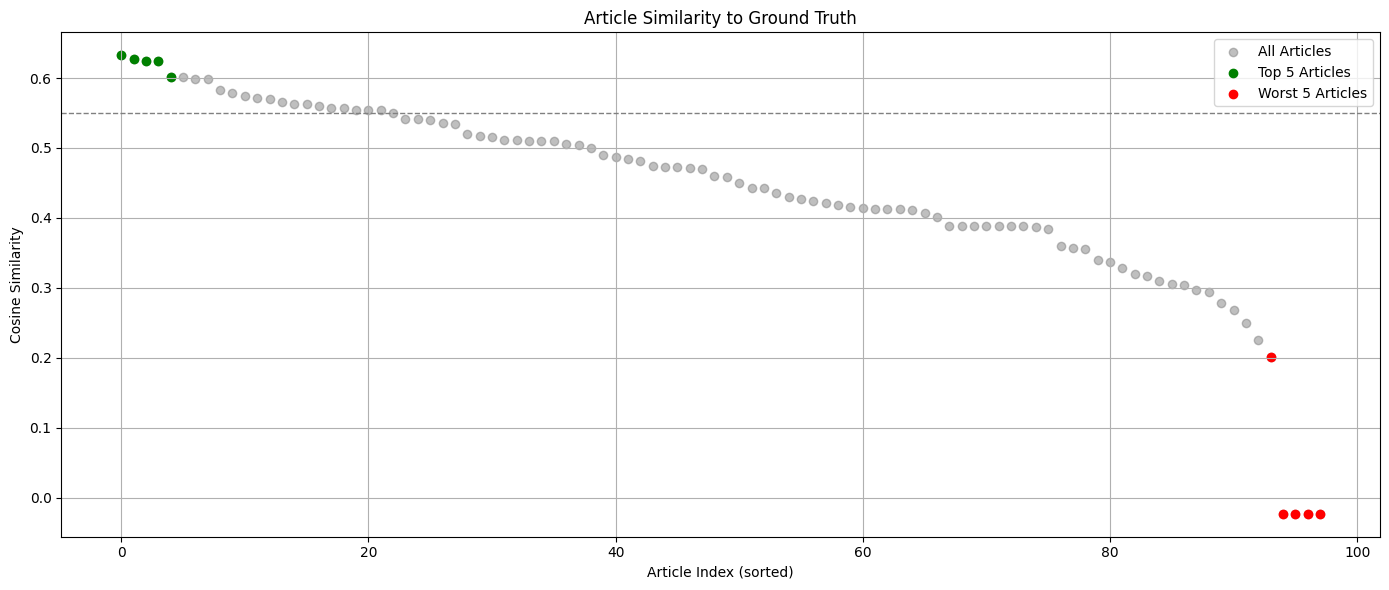

Top 5 Articles (Most Similar to Ground Truth):


,source,title,similarity_to_ground_truth
0,gamereactor.eu,"Barça and Arsenal rise, City sinks: the final ...",0.632552
1,freepressjournal.in,Arsenal Vs Real Madrid LIVE streaming: When & ...,0.626828
2,espn.co.uk,"Champions League final, Premier League race: M...",0.624995
3,espn.com,"Champions League final, Premier League race: M...",0.624995
4,espn.co.uk,Champions League final early look: Real Madrid...,0.601405


Bottom 5 Articles (Least Similar to Ground Truth):


,source,title,similarity_to_ground_truth
93,rnz.co.nz,"AS Pirae, Auckland City to face off in OFC Cha...",0.200611
94,japantoday.com,Kewell seeks coaching redemption in AFC Champi...,-0.023169
95,japantoday.com,Yokohama reach Asian Champions League semifinals,-0.023169
96,japantoday.com,Footballers' union FIFPRO says AFC Champions L...,-0.023169
97,japantoday.com,Kewell leads Yokohama into Asian Champions Lea...,-0.023169


In [33]:
import matplotlib.pyplot as plt
import pandas as pd

# Sort and classify
df_sorted = df_scored.sort_values('similarity_to_ground_truth', ascending=False).reset_index(drop=True)
outlier_threshold = 0.55
outliers = df_sorted[df_sorted['similarity_to_ground_truth'] < outlier_threshold]
core_articles = df_sorted[df_sorted['similarity_to_ground_truth'] >= outlier_threshold]

# Identify top and worst 5
top5 = df_sorted.head(5).copy()
worst5 = df_sorted.tail(5).copy()

# Plot
plt.figure(figsize=(14, 6))
plt.scatter(df_sorted.index, df_sorted['similarity_to_ground_truth'], color='gray', alpha=0.5, label='All Articles')
plt.scatter(top5.index, top5['similarity_to_ground_truth'], color='green', label='Top 5 Articles')
plt.scatter(worst5.index, worst5['similarity_to_ground_truth'], color='red', label='Worst 5 Articles')

# Threshold line
plt.axhline(y=outlier_threshold, color='gray', linestyle='--', linewidth=1)

# Labels and legend
plt.title("Article Similarity to Ground Truth")
plt.xlabel("Article Index (sorted)")
plt.ylabel("Cosine Similarity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Display summary tables
print("Top 5 Articles (Most Similar to Ground Truth):")
display(top5[['source', 'title', 'similarity_to_ground_truth']])

print("Bottom 5 Articles (Least Similar to Ground Truth):")
display(worst5[['source', 'title', 'similarity_to_ground_truth']])


## References

- [TheNewsAPI](https://www.thenewsapi.com/) – News aggregation API used to fetch articles.
- [spaCy](https://spacy.io/) – Industrial-strength natural language processing library for entity extraction and linguistic analysis.
- [en_core_web_lg](https://spacy.io/models/en#en_core_web_lg) – Pretrained large English language model used with spaCy for named entity recognition and vector embeddings.
- [sentence-transformers](https://www.sbert.net/) – Library for generating sentence and document embeddings using pretrained transformer models.
- [all-MiniLM-L6-v2 model](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) – Lightweight transformer model used for computing semantic similarity between texts.
- [newspaper3k](https://newspaper.readthedocs.io/en/latest/) – Python library used to extract and clean full-text content from news article URLs.
- [pandas](https://pandas.pydata.org/) – Library for data analysis and manipulation in Python.
- [matplotlib](https://matplotlib.org/) – Library used for plotting article similarity scores.
- [Python 3.10](https://www.python.org/downloads/release/python-31013/) – Version used to ensure compatibility across all libraries and dependencies.
